In [1]:
import os
import rpy2
import scipy
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
import scrublet as scr
import decoupler as dc
from scipy import sparse
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from typing import Optional, Union
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.5.0
absl                        NA
anndata2ri                  1.1
appnope                     0.1.3
asttokens                   NA
attr                        23.1.0
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
decoupler                   1.4.0
deprecate                   0.3.2
dot_parser                  NA
executing                   1.2.0
fsspec                      2023.6.0
functions                   NA
google                      NA
gsva_prep                   NA
h5py                        3.9.0
igraph                      0.10.4
ipykernel                   6.23.2
ipywidgets                  8.0.6
jedi                        0.18.2
jinja2                      3.1.2
joblib        

## **1. Reading in the data**

### **Prepare data**

Now, we load the preprocessed and annotated data for differential pathway analysis.

Make sure the anndata has the count data in either `.layers` or in `.X`. if count data is not in `.layers` it will be assumed that `.X ` contains the counts

Please set `get_cell_types=True` if, `cell_type` column is absent or contains celltype annotation not of the form

- `Excitatory`, `Inhibitory`, `Astrocyte`, `Oligodendrocyte`, `OPC`, `Microglia`, `Endothelial`.

In [20]:
save_prefix = 'seaad_mtg'
get_cell_types = False

In [21]:
adata_annot = sc.read_h5ad(f'../data/raw/{save_prefix}/{save_prefix}_raw_anndata.h5ad')

if 'counts' not in adata_annot.layers.keys():
    adata_annot.layers['counts'] = adata_annot.X.copy()
else:
    adata_annot.X = adata_annot.layers['counts'].copy()

adata_annot

AnnData object with n_obs × n_vars = 154368 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mon

Specify the way to map cells to appropriate cell-types

In [6]:
celltypes = ["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC", 'Endothelial'] 
#"Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC", "Endothelial"

mapping = {'leng_etc':
           
           {'Exc': 'Excitatory', 
            'Inh': 'Inhibitory', 
            'Astro': 'Astrocyte',
            'Endo': 'Endothelial', 
            'Micro': 'Microglia', 
            'OPC': 'OPC', 
            'Oligo': 'Oligodendrocyte'},

           'leng_sfg':
           
           {'Exc': 'Excitatory', 
            'Inh': 'Inhibitory', 
            'Astro': 'Astrocyte',
            'Endo': 'Endothelial', 
            'Micro': 'Microglia', 
            'OPC': 'OPC', 
            'Oligo': 'Oligodendrocyte'},
           
           'allen_mtg':
           
           {'Excitatory': 'Excitatory', 
            'Inhibitory': 'Inhibitory',
            'Astrocyte': 'Astrocyte',
            'Microglia': 'Microglia', 
            'Endothelial': 'Endothelial', 
            'OPC': 'OPC',
            'Oligodendrocyte': 'Oligodendrocyte'},
            
            'seaad_mtg':
           
           {'Excitatory': 'Excitatory', 
            'Inhibitory': 'Inhibitory',
            'Astrocyte': 'Astrocyte',
            'Microglia': 'Microglia', 
            'Endothelial': 'Endothelial', 
            'OPC': 'OPC',
            'Oligodendrocyte': 'Oligodendrocyte'},
            }

cell_column = {'leng_etc': 'clusterCellType',
               'leng_sfg': 'clusterCellType',
               'allen_mtg': 'cell_labels',
               'seaad_mtg': 'cell_type',
               }

In [7]:
if get_cell_types:
    adata_annot.obs['cell_type'] = adata_annot.obs[cell_column[save_prefix]].map(mapping[save_prefix])

adata_annot = adata_annot[adata_annot.obs.cell_type.isin(celltypes)]

### **Prepare Meta-data**

Now we specify other related information

Specify the following:

- `metadata`: Path to metadata. Metadata must contain a column called `pathology.group` with the only unique groups being `no`, `early`, and `late`.

- `test_names`: List of the different test names of interest. This will only affect the tests that will be saved and not the overall linear model used in the design matrix itself as all contrasts (tests) will still be accounted for in the linear model.

- `control_group`: Name of control group in metadata. This should ideally be `no`, representing the control group 

- `subject_id`: Name of the column containing Subject/Patient ID in metadata and `.obs`

- `covariates`: This should be a list of additional confounding covariates (`not including pathology.group`) e.g `Sex`, `Sample Batch`, `Age` and other factors that might not be of interest but might have an effect on the pathological status. If you would not like to include any cofounders, please set `covaraites = ['None']`.

    -  For the `Mathys` data the only covariate included is `msex_x`
    -  For the `Leng` data the no covariate was included so `None` was included 

- `save_prefix`: Prefix for saving critical files. preferably chosen to be in the format `{source name}_{brain region}`. e.g `mathys_pfc`
        

In [8]:
control_group = 'no'                    # name of the control group in metadata 

covaraites_for_study = {'allen_mtg': ['None'], # ['ageDeath.cat', 'sex_y',],
                        'leng_sfg': ['None'],  # ['ageDeath.cat',],
                        'leng_etc': ['None'],  # ['ageDeath.cat',]
                        'seaad_mtg': ['None']
                        }

subject_ids_for_study = {'allen_mtg': 'individualID',
                        'leng_sfg': 'PatientID',
                        'leng_etc': 'PatientID',
                        'seaad_mtg': 'individualID'}

bio_covariates = covaraites_for_study[save_prefix]  # list of covariates to be accounted for in regression.
technical_covariate = 'SampleBatch'                 # Technical covariate to be included as random effect not of interest (regressed out by duplicatecorrection)
duplicate_correction = 'FALSE'                      # whether to run duplicate corretion in Limma to block out technical_covariate
gene_celltype_threshold = 0.10                      # determines number of cells the gene must be expressed in
filter_genes_from = 'pseudobulk'                    # whether to filter genees after aggregating pseudobulks or from single_cell object 
pathway_gene_threshold = 0.33                       # determines number of genes that must be present in that pathway
subject_id = subject_ids_for_study[save_prefix]     # for leng this is `PatientID` for mathys is 'Subject', and allen is 'individualID'
pseudobulk_method = 'agg_x_norm'                    # method for aggregrating cells from replicates into pseudobulks.

metadata = f'../data/raw/{save_prefix}/{save_prefix}_metadata.csv'

test_names = ['early_vs_no', 'late_vs_early', 'late_vs_no', 'ad_vs_no']

### **Normalize and Log Transform AnnData**

In [9]:
# if 'counts' in adata_annot.layers.keys():
#     print('normalizaing data using count data in .layers["counts] ')
#     adata_annot.X = adata_annot.layers['counts'].toarray().copy()
#     sc.pp.normalize_total(adata_annot, target_sum=1e04)
#     sc.pp.log1p(adata_annot)
# else:
#     print('normaling data using count data in .X')
#     adata_annot.layers['counts'] = adata_annot.X
#     sc.pp.normalize_total(adata_annot, target_sum=1e04)
#     sc.pp.log1p(adata_annot)

#### **Normalization using [**Joel W. Blanchard et. al.**](https://github.com/djunamay/apoe4myelin/blob/main/functions/qc_and_annotation_aux_functions.r) strategy** 

In [10]:
#adata_annot = pathway_analyses.normalize_default(adata_annot, log_scale=True)

#### **Normalization With [ACTIONet](https://github.com/shmohammadi86/ACTIONet/blob/python-devel/ACTIONet/preprocessing/normalization.py) strategy** 

In [11]:
adata_annot = pathway_analyses.normalize_actionet(adata_annot, layer_key = 'counts', layer_key_out = None, 
                                                    top_features_frac = 1.0, scale_factor = "median", 
                                                    transformation = "log", anchor_features = None, copy = True)

## **2.4 Systematic differential analysis of pathway activity**

Motivated by findings from [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), we perform differential pathway activity analysis using pathways obtained from the following databases (downloaded from the Mayaan laboratory; https://maayanlab.cloud/ Enrichr/#libraries):

- Gene Ontology biological processes (2018),
- KEGG (2019), 
- Reactome (2016) 
- and HumanCyc (2016) 


### **Load and Process Pathways**

In [12]:
bp = pathway_analyses.read_pathways('../data/pathway_databases/GO_Biological_Process_2018.txt')
cy = pathway_analyses.read_pathways('../data/pathway_databases/HumanCyc_2016.txt')
ke = pathway_analyses.read_pathways('../data/pathway_databases/KEGG_2019_Human.txt')
re = pathway_analyses.read_pathways('../data/pathway_databases/Reactome_2016.txt')

all_paths = pd.concat([bp, cy, ke, re], join='outer', axis=0, ignore_index=True)
all_paths.set_index(0, inplace=True)
all_paths.fillna("", inplace=True)
all_paths_dict = all_paths.to_dict(orient='index')


go_bp_paths = bp.set_index(0)
go_bp_paths.fillna("", inplace=True)
go_bp_paths_dict = go_bp_paths.to_dict(orient='index')


gene_set_by_path = {key: [val for val in value.values() if val != ""] for key, value in go_bp_paths_dict.items()}
gene_set_by_path = pd.DataFrame.from_dict(gene_set_by_path, orient='index').transpose()

/Users/tadeoye/Documents/Research codes/scRNA_seq_meta_analysis/scripts/functions/pathway_analyses.py:225: DtypeWarning: Columns (488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,70

### **Expressed Genes Per cell-type**

Next, we follow the protocol described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), and filter out genes not expressed in a significantly across a cell type. As in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), we retain genes that are expressed `in > 10%` of cells in that cell type using the gene counts stored in `.layers`


This filtereing is expected to minimize the discovery of false positive effects on pathway activity scores computed in a downstream step.

In [13]:
expressed_genes_per_celltype = pathway_analyses.filter_expressed_genes_by_celltype(adata_annot, threshold=gene_celltype_threshold, 
                                                                                   filter_genes_from = filter_genes_from,
                                                                                   subject_id = subject_id)

gene_set_per_celltype = pathway_analyses.filter_lowly_exp_genes(expressed_genes_per_celltype, gene_set_by_path, 
                                                                threshold=pathway_gene_threshold)

### **Aggregate Individual Level Averages Per cell-type**

To prepare the data for pathway analysis, we calculate normalized gene expression profile averages for each individual and cell type. We achieve this by computing averaged expression profiles using the `get_ind_level_ave` function, which employs one of two methods:

Next, we calculate individual-cell-type-level normalized gene expression profile averages that will be fed into the pathway analysis module.

The function  computes the averaged expression profile for each cell type and individual. Using one of two methods;


- **Aggregrate Pseubulk Then Normalize(`agg_x_norm`)**:

    - In this method, a pseudobulk profile is generated using `decoupler.get_pseudobulk()`, and the count data is log-normalized according to the protocol outlined in [**ACTIONet**](https://www.nature.com/articles/s41467-020-18416-6). This involves normalizing the counts to the mean library size, scaled to the median.

     decoupler.get_pseudobulk(), and the count data is log-normalized according to the protocol outlined in ACTIONet. This involves normalizing the counts to the mean library size, scaled to the median.

- **Normalize then Aggregate (`norm_x_agg`)**:

    - In this method, individual-cell-type-level normalized gene expression profiles are obtained by aggregating the normalized values obtained from  [**ACTIONet**](https://www.nature.com/articles/s41467-020-18416-6) and stored in the  `.X` attribute. This is the aggregation protocol is described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w).
    
IIn both methods, we retain only the genes that meet the filtering threshold described in the previous section.  This is done by setting `filter_genes_at_threshold = True` and passing the dictionary of expressed genes in each cell type to `expressed_genes_per_celltype`

In [14]:
avs_logcounts_cellxind  = pathway_analyses.get_ind_level_ave(adata_annot, subject_id, pseudobulk_method, 
                                                             expressed_genes_per_celltype, filter_genes_at_threshold=True)

Now Let's confirm that the filtered data contains a reasonable proportion of AD risk genes reproted in previous literature

In [15]:
ad_genes = pd.read_csv('../data/pathway_databases/AD_genes.csv')

for cell_type in avs_logcounts_cellxind.keys():
    print(f'There are {sum(avs_logcounts_cellxind[cell_type].index.isin(ad_genes.Symbol))} AD-associated genes in {cell_type} cells')

There are 31 AD-associated genes in Excitatory cells
There are 36 AD-associated genes in Inhibitory cells
There are 32 AD-associated genes in Astrocyte cells
There are 31 AD-associated genes in Oligodendrocyte cells
There are 36 AD-associated genes in OPC cells
There are 42 AD-associated genes in Microglia cells
There are 42 AD-associated genes in Endothelial cells


### **Prep data for Gene Set Variation Analysis in R**

In [16]:

for cell_type in adata_annot.obs.cell_type.unique():
    prep_gsva(avs_logcounts_cellxind[cell_type], gene_set_per_celltype[cell_type], 
              tempdir=f'../results/gsva/{save_prefix}/{cell_type}/', verbose=False)

### **Estimate Pathway Activity Scores**

After estimating individual-cell-type-level normalized gene expression profile averages, we next calculated pathway activity scores, as described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w) and previously implemented in the R package (Gene Set Variational Analysis) GSVA (v.1.42.0)41. 

Briefly, GSVA estimates a normalized relative expression level per gene across samples. This expression level is then rank-ordered for each sample and aggregated into gene sets by calculating sample-wise enrichment scores using a Kolmogorov–Smirnov-like rank statistic.

As described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), we used the parameters to evaluate the 
GSVA function:

- `mx.diff=TRUE` 
- `kcdf=c("Gaussian")`
- `min.sz=5` 
- `max.sz=150`

Here, we instead set `max.sz=500`, as described in the [**GSVA Tutorial**](http://www.bioconductor.org/packages/release/bioc/vignettes/GSVA/inst/doc/GSVA.html#5_Quantification_of_pathway_activity_in_bulk_microarray_and_RNA-seq_data)

The authors report that ...

`Activity scores computed this way accurately recovered cell type signatures that were not recovered by equally sized randomly sampled gene sets, suggesting that this approach captures transcriptomically encoded biological signals in snRNA-seq data`

In [17]:
%%R -o gsva_scores -i save_prefix -i celltypes

library(GSEABase)
library(GSVA)
library(tidyr)
library(dplyr)

# create an empty list to store the output for each celltype
gsva_scores = list()

# iterate over celltypes and perform gsva
for (celltype in celltypes) {
    # get gene sets
    geneSets = getGmt(file.path('../results/gsva/', save_prefix, '/', celltype, 'gs.gmt'))
    geneSets = geneIds(geneSets)

    # read in expression data
    mat = as.matrix(read.csv(file.path('../results/gsva/', save_prefix, '/', celltype, 'expr.csv'), header=TRUE, row.names=1, check.names=FALSE))
    
    # run gsva
    print(paste0("Estimating Pathway Activity Scores in ", celltype, " Cells"))
    print("........")
    exc_gsva = gsva(mat, geneSets, mx.diff=TRUE, kcdf=c("Gaussian"), min.sz=5, max.sz = 500)
    
    # Convert matrix to data frame and gather into "long" format
    exc_gsva <- as.data.frame(exc_gsva, stringsAsFactors = FALSE)

    # store the output in a list
    gsva_scores[[celltype]] = exc_gsva

    write.csv(gsva_scores[[celltype]], file = file.path('../results/gsva/', save_prefix, '/', celltype, 'gsva_scores.csv'))
}


[1] "Estimating Pathway Activity Scores in Excitatory Cells"
[1] "........"
Estimating GSVA scores for 1576 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] "Estimating Pathway Activity Scores in Inhibitory Cells"
[1] "........"
Estimating GSVA scores for 2058 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] "Estimating Pathway Activity Scores in Astrocyte Cells"
[1] "........"
Estimating GSVA scores for 2447 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] "Estimating Pathway Activity Scores in Microglia Cells"
[1] "........"
Estimating GSVA scores for 3045 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] "Estimating Pathway Activity Scores in Oli

Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

Loading required package: annotate
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: IRanges
Loading r

### **Differential pathway activity analysis**

Next, o investigate differential pathway activity across different cell types, we utilized a multivariate linear model approach, as described in [**Joel W. Blanchard et. al.**](https://doi.org/10.1038/s41586-022-05439-w), using pathway activity scores. 

The design matrix is consequently: 

`pathway activity ~ β0 × AD + β1 × msex + β2 × age_death.`

`β0` represents the effect of AD on pathway activity, when accounting for confounding variables that might be correlated with, and therefore explain, a portion of the variation observed in the activity of a pathway of interest. 

Here, AD is a binary variable, encoding the pathological status. Amyloid and nft are averages of continuous measurements of pathology, as evaluated and reported by ROSMAP. Age_death is a continuous measurement indicating age at death, pmi represents the PMI (a continuous measurement) and sex is a binary variable encoding biological sex.

Using this approach, we can model pathway activity scores for each pathway-cell type combination, accounting for various biological covariates, including AD, sex, age_death, and measures of amyloid and nft pathology as evaluated and reported in the metadata. 

To avoid mixing technical and biological covariates in the same model, we treat technical covraiates (such ad Sample Batch) which are not of interest as random effects. More so, initial exploratory analysis revealed nested factors and matrices without full rank. As a result, the resultant design matrix had some columns that are linearly dependent, which is due to batch information being redundant since certain batches are uniquely defined by one group. We noticed that the design matrix is not of full rank since the parameter estimation process returned a "non-estimable" warning for some parameters. 

To remedy this, we treat factors that are not of direct interest as random effects, by assigning the technical covraites as the blocking variable. We used the limma package's duplicateCorrelation method to account for this, which is especially useful when a batch covariate is partially confounded with the covariate of interest. resulting in a rank-deficient model. However, for the current iteration of our work, we set `duplicate_correction = 'FALSE'`. 

We also accounted for other biological factors such as sex and age_death by passing them as a list of `bio_covariates`. For this current iteration, we set `bio_covariates = ['None']`. According to [**Charity W. Law et al.**](https://doi.org/10.12688/f1000research.27893.1), an effective method for identifying additional factors to be considered is through the utilization of unsupervised clustering plots like principal components analysis (PCA). In all the studies examined, no other factors were found to be associated with the separation between sample clusters, leading to their exclusion from the model.

The linear models were fitted using the `lmfit()` function and t-statistics were computed using the `eBayes()` function from the Limma R package (v.3.50.3). 

To prioritize candidate AD-dysregulated processes, pathways with snRNA-seq evidence of association with AD at a `nominal P value of 0.05` are considered to be potential candidates. This procedure will result in prioritized candidate pathways for all cell types. 

The linear models were fitted using the lmfit() function and t-statistics were computed using the eBayes() function from the Limma R package (v.3.50.3).

In [18]:
%%R -o all_data -i control_group -i metadata -i subject_id -i bio_covariates -i save_prefix -i technical_covariate -i duplicate_correction -i test_names

library(limma)
library(magrittr)
library(tidyr)

source('../scripts/functions/pathway_analyses.R')

summary = read.csv(metadata)
#control_group = paste(control_group, 'pathology', sep='-')
summary$AD = ifelse(summary$pathology.group == control_group, 0, 1)
rownames(summary) = summary[, subject_id]


gsva_scores = list()
# iterate over celltypes and perform limma
for (celltype in celltypes) {

    # read in pathway scores
    pathway_scores = as.matrix(read.csv(file.path('../results/gsva/', save_prefix, '/', celltype, 'gsva_scores.csv'), header=TRUE, row.names=1, check.names=FALSE))

    # store the output in a list
    gsva_scores[[celltype]] <- t(pathway_scores)
} 

all_data = list()

all_data[['gsva_out']] = gsva_scores

# get linear model fits
print('getting linear model fits...')
fits = get_fits(gsva_scores, summary, bio_covariates, technical_covariate)
all_data[['fits_all']] = fits

# get matrix of scores for heatmap
print('get matrix of scores')
scores = get_scores(fits)

# Create a new empty list to store the reorganized scores
new_scores <- list()

# Loop over the different tests
tests <- test_names
for (test in tests) {
  
  # Create a new empty list for this test
  new_scores[[test]] <- list('all' = list())
  
  # Loop over the different cell types
  for (cell_type in celltypes) {
    
    # Copy the scores for this cell type and test
    new_scores[[test]][['all']][[cell_type]] <- scores[['all']][[cell_type]][[test]]
    
  }
}

# save new_scores in list
all_data[['scores_all']] = new_scores

print('filter by score 1.3')
# Extract unique gene names from scores object
all_data[['scores_filtered']] = list()
for(i in names(new_scores)){
    names = unique(unname(unlist(lapply(names(new_scores[[i]]$all), function(x) rownames(new_scores[[i]]$all[[x]])))))
    # Get a matrix of gene set scores for all samples
    mat = get_matrix(new_scores[[i]]$all, names)
    # Keep only rows with absolute values > 1.3 in at least one sample
    mat = mat[unname(rowSums(abs(mat)>1.3)>0),]

    # if(top_20==TRUE){
    #     index = unique(unname(unlist(lapply(colnames(mat), function(x) order(abs(mat[[x]]),decreasing = T)[1:20]))))
    #     mat = mat[index,]
    # }
    all_data[['scores_filtered']][[i]] = mat
}


[1] "getting linear model fits..."
[1] "get matrix of scores"
[1] "filter by score 1.3"



Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



### Significant Pathway Selection

In [19]:
valid_pathways = {}
all_pathways = {}

for test_name in test_names:
    valid_pathways[test_name] = {}
    all_pathways[test_name] = pd.DataFrame()
    # Loop through each unique cell type in the cell_type column of adata_annot and filter statistically significant pathways
    for cell_type in adata_annot.obs.cell_type.unique():
        try:
            # Create a dataframe for the current cell type from a matrix in all_data, rename and set index.
            valid_pathways[test_name][cell_type] = pd.DataFrame(all_data['scores_filtered'][test_name][cell_type])
            all_data['scores_all'][test_name]['all'][cell_type].index.name = 'pathway'
            valid_pathways[test_name][cell_type].index.name = 'pathway'
            valid_pathways[test_name][cell_type].rename(columns={cell_type: 'score_adj'}, inplace=True)

            # Merge current cell type dataframe with its corresponding scores_all dataframe on "pathway" and remove missing rows
            valid_pathways[test_name][cell_type] = valid_pathways[test_name][cell_type].merge(all_data['scores_all'][test_name]['all'][cell_type],
                                                     how='outer', on='pathway')
            valid_pathways[test_name][cell_type].dropna(axis=0, inplace=True)

            # Filter rows with P.Value less than 0.05 from the current cell type dataframe and sort by P.Value    
            # valid_pathways[test_name][cell_type] = valid_pathways[test_name][cell_type][valid_pathways[test_name][cell_type]['P.Value']<0.05]
            valid_pathways[test_name][cell_type].sort_values(by='P.Value', inplace=True)
            
            # Append the current cell type's dataframe to the all_pathways dataframe and sort by pathway
            all_pathways[test_name] = pd.concat([all_pathways[test_name], valid_pathways[test_name][cell_type]], axis=0)
            all_pathways[test_name].sort_values(by='pathway', inplace=True)
        except KeyError:
            continue

### Renaming convention

In [20]:
# Read in a CSV file containing the renaming convention for pathway names
# Remove duplicate names in the renaming convention dataframe
renaming_convention = pd.read_csv('../data/pathway_databases/renaming_convention.csv', dtype=str)
renaming_convention.drop_duplicates(subset='names', inplace=True)

for test_name in test_names:
    # Reset the index of the all_pathways dataframe to allow merging with renamed convention
    all_pathways[test_name].reset_index(inplace=True)
    all_pathways[test_name] = pd.merge(all_pathways[test_name], renaming_convention[['names', 'shortened', 'highlight']], how='left', on='names')
    all_pathways[test_name].set_index(keys='pathway', inplace=True)
    all_pathways[test_name] =  all_pathways[test_name].astype(object).replace(np.nan, 'None')


    dat_dir = f'../results/{test_name}/{save_prefix}/Data/'

    if not os.path.exists(dat_dir):
        os.makedirs(dat_dir)

    # Write the all_pathways dataframe to a CSV file
    all_pathways[test_name].to_csv(dat_dir+'differentially_expressed_pathways.csv')

### Heat Map

Filtered Cell-type-specific Pathways

In [21]:
# for test_name in test_names:
#     print(f'heatmap for select cell-type-specific pathways in {test_name} test')
#     list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
#     df = all_pathways[test_name][all_pathways[test_name]['P.Value']<0.05]

#     fig_dir = f'../results/{test_name}/{save_prefix}/HeatMap/'
#     if not os.path.exists(fig_dir):
#         os.makedirs(fig_dir)
        
#     save_path = fig_dir+'filtered_cell_type_specific_diff_exp_paths.pdf'

#     pathway_analyses.plot_and_select_top_deps(df, list_of_paths_to_annotate, save_prefix=save_prefix,
#                          save_path=save_path, filter=True, cell_type_specific=True, 
#                          test_name=test_name, cell_types=celltypes)

All Cell-type-specific Pathways

heatmap for all cell-type-specific pathways in early_vs_no test


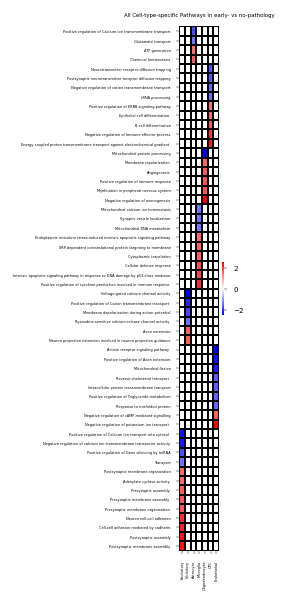

heatmap for all cell-type-specific pathways in late_vs_early test


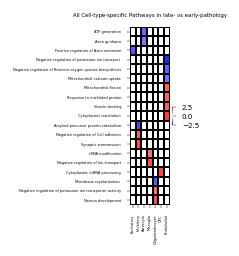

heatmap for all cell-type-specific pathways in late_vs_no test


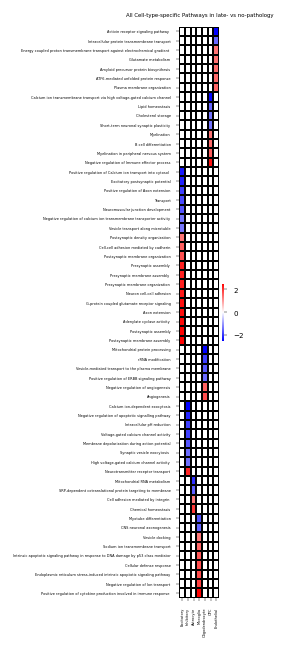

heatmap for all cell-type-specific pathways in ad_vs_no test


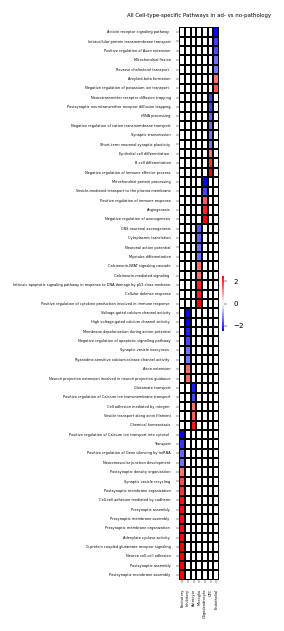

In [22]:
for test_name in test_names:
    print(f'heatmap for all cell-type-specific pathways in {test_name} test')
    list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
    df = all_pathways[test_name][all_pathways[test_name]['P.Value']<0.05]

    fig_dir = f'../results/{test_name}/{save_prefix}/HeatMap/'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        
    save_path = fig_dir+'all_cell_type_specific_diff_exp_paths.pdf'
    
    pathway_analyses.plot_and_select_top_deps(df, list_of_paths_to_annotate, save_prefix=save_prefix,
                         save_path=save_path, filter=False, cell_type_specific=True, 
                         test_name=test_name, cell_types=celltypes)


Filtered Shared Pathways

In [23]:
# for test_name in test_names:
#     print(f'heatmap for select shared pathways in {test_name} test')
#     list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
#     df = all_pathways[test_name][all_pathways[test_name]['P.Value']<0.05]


    # fig_dir = f'../results/{test_name}/{save_prefix}/HeatMap/'
    # if not os.path.exists(fig_dir):
    #     os.makedirs(fig_dir)
        
    # save_path = fig_dir+'filtered_broad_diff_exp_paths.pdf'

#     pathway_analyses.plot_and_select_top_deps(df, list_of_paths_to_annotate, save_prefix=save_prefix,
#                          save_path=save_path, filter=True, cell_type_specific=False, 
#                          test_name=test_name, cell_types=celltypes)


All shared Pathways

heatmap for all shared pathways in early_vs_no test


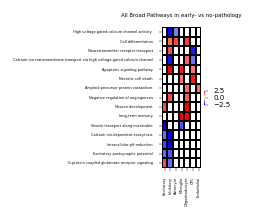

heatmap for all shared pathways in late_vs_early test


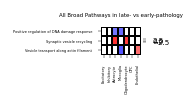

heatmap for all shared pathways in late_vs_no test


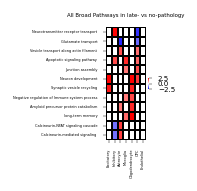

heatmap for all shared pathways in ad_vs_no test


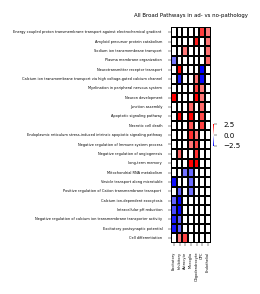

In [24]:
from functions import pathway_analyses

for test_name in test_names:
    print(f'heatmap for all shared pathways in {test_name} test')
    list_of_paths_to_annotate = list(all_pathways[test_name].shortened[all_pathways[test_name].highlight=='yes'])
    df = all_pathways[test_name][all_pathways[test_name]['P.Value']<0.05]

    
    fig_dir = f'../results/{test_name}/{save_prefix}/HeatMap/'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        
    save_path = fig_dir+'all_broad_diff_exp_paths.pdf'
    
    pathway_analyses.plot_and_select_top_deps(df, list_of_paths_to_annotate, save_prefix=save_prefix,
                         save_path=save_path, filter=False, cell_type_specific=False, 
                         test_name=test_name, cell_types=celltypes)
    